# Purpose

Attempt to perform a logistic regression on the cves/metasploit dataset

In [142]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


%matplotlib inline


In [1]:
CVES_METASPLOIT_ENCODED = '../../data/processed/cves_metasplot_encoded.json'

In [3]:
cves_df = pd.read_json(CVES_METASPLOIT_ENCODED)
cves_df.head()

,access_ADJACENT_NETWORK,access_LOCAL,access_NETWORK,access_PHYSICAL,auth_HIGH,auth_LOW,auth_MULTIPLE,auth_NONE,auth_SINGLE,avail_COMPLETE,...,conf_LOW,conf_NONE,conf_PARTIAL,id,integ_COMPLETE,integ_HIGH,integ_LOW,integ_NONE,integ_PARTIAL,metasploit
0,0,0,1,0,0,0,0,1,0,0,...,0,1,0,CVE-1999-0001,0,0,0,1,0,0
1,0,0,1,0,0,0,0,1,0,1,...,0,0,0,CVE-1999-0002,1,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,1,...,0,0,0,CVE-1999-0003,1,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,...,0,1,0,CVE-1999-0004,0,0,0,1,0,0
4,0,0,1,0,0,0,0,1,0,1,...,0,0,0,CVE-1999-0005,1,0,0,0,0,0


In [7]:
cves_df['metasploit'].value_counts()

0    101310
1      1637
Name: metasploit, dtype: int64

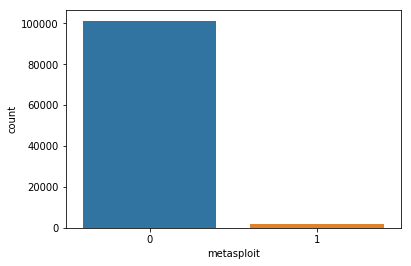

In [6]:
sns.countplot(x='metasploit', data=cves_df)

In [8]:
cves_df.groupby('metasploit').mean()

,access_ADJACENT_NETWORK,access_LOCAL,access_NETWORK,access_PHYSICAL,auth_HIGH,auth_LOW,auth_MULTIPLE,auth_NONE,auth_SINGLE,avail_COMPLETE,...,conf_COMPLETE,conf_HIGH,conf_LOW,conf_NONE,conf_PARTIAL,integ_COMPLETE,integ_HIGH,integ_LOW,integ_NONE,integ_PARTIAL
metasploit,,,,,,,,,,,,,,,,,,,,,
0,0.023571,0.164989,0.809091,0.002349,0.011282,0.068641,0.000622,0.860715,0.058740,0.170250,...,0.147142,0.169381,0.052660,0.293436,0.33738,0.141753,0.147369,0.047083,0.280397,0.383397
1,0.005498,0.064142,0.930360,0.000000,0.004887,0.034820,0.000000,0.896151,0.064142,0.465486,...,0.461820,0.139279,0.005498,0.078803,0.31460,0.454490,0.119731,0.006109,0.139279,0.280391


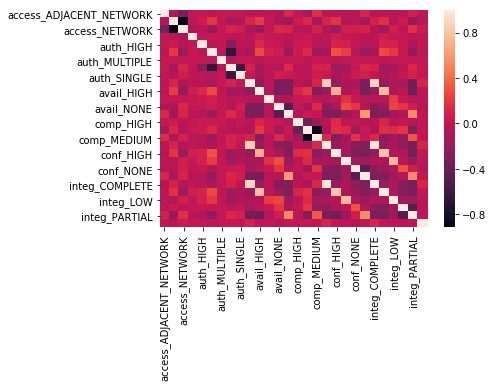

In [11]:
sns.heatmap(cves_df.corr())


In [29]:
cves_df.columns

Index(['access_ADJACENT_NETWORK', 'access_LOCAL', 'access_NETWORK',
       'access_PHYSICAL', 'auth_HIGH', 'auth_LOW', 'auth_MULTIPLE',
       'auth_NONE', 'auth_SINGLE', 'avail_COMPLETE', 'avail_HIGH', 'avail_LOW',
       'avail_NONE', 'avail_PARTIAL', 'comp_HIGH', 'comp_LOW', 'comp_MEDIUM',
       'conf_COMPLETE', 'conf_HIGH', 'conf_LOW', 'conf_NONE', 'conf_PARTIAL',
       'id', 'integ_COMPLETE', 'integ_HIGH', 'integ_LOW', 'integ_NONE',
       'integ_PARTIAL', 'metasploit'],
      dtype='object')

In [31]:
X = cves_df.drop(['metasploit', 'id'], axis=1)
y = cves_df['metasploit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [32]:
y_train.mean()

0.01563269006605362

In [33]:
y_test.mean()

0.01670746396238878

In [46]:
classifier = LogisticRegression(random_state=0, class_weight="balanced")
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [49]:
y_pred = classifier.predict(X_test)


In [54]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)


Predicted,0,1,All
True,,,
0,15592,9715,25307
1,102,328,430
All,15694,10043,25737


In [50]:
print(confusion_matrix(y_test, y_pred))

[[15592  9715]
 [  102   328]]


In [51]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.62


In [52]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.62      0.76     25307
          1       0.03      0.76      0.06       430

avg / total       0.98      0.62      0.75     25737



out of the 25737 CVEs we have only 430 of them required us to inspect them, the predictor said to inspect 10043, so we looked at nearly 40%, or another way, we had a 60% reduction in cves to inspect.  That's good, but not great, specially since it resulted in missing nearly 25% of the positives: 102 were exploited without triggering a positive.  Much like SPAM, we want to minimize False Negatives

In [59]:
y_pred_prob = classifier.predict_proba(X_test)

In [107]:
y_pred_thresh = [1 if pred[1] > thresh else 0 for pred in y_pred_prob]
matrix = confusion_matrix(y_test, y_pred_thresh)
(matrix[1][0], matrix[0][1]+matrix[1][1])

(102, 10043)

In [156]:
def get_fp(thresh):
    y_pred_thresh = [1 if pred[1] > thresh else 0 for pred in y_pred_prob]
    matrix = confusion_matrix(y_test, y_pred_thresh)
    return (matrix[1][1], matrix[0][1]+matrix[1][1])

fp_x = []
fp_y = []
pos_y = []
for a in range(100, 0, -1):
    thresh = a/100
    fp = get_fp(thresh)
    fp_y.append(fp[0])
    pos_y.append(fp[1])
    fp_x.append(thresh)

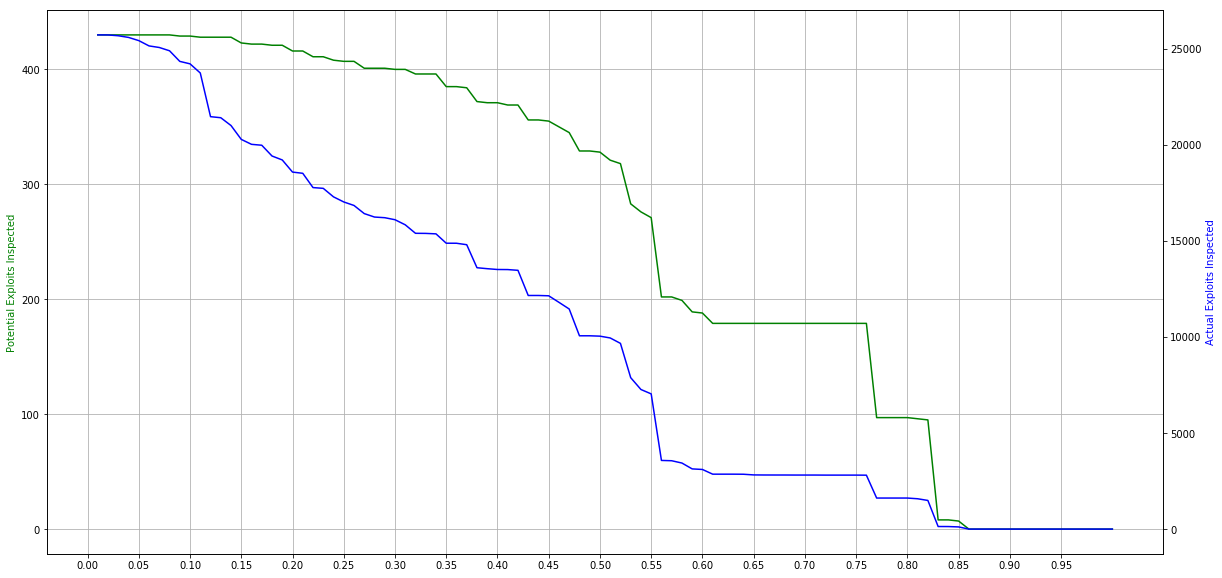

In [174]:

fig, ax1 = plt.subplots(figsize=(20,10))

ax2 = ax1.twinx()
ax1.plot(fp_x, fp_y, 'g')
ax2.plot(fp_x, pos_y, 'b')

ax1.set_ylabel('Potential Exploits Inspected', color='g')
ax2.set_ylabel('Actual Exploits Inspected', color='b')
xticks = [x/100 for x in range(0,100,5)]
plt.xticks(xticks)
#plt.axvline(x=0.15)
ax1.grid(True)

#plt.axvline(x=0.5)
#plt.plot(x[0], y[0], 'g*')

In [140]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [176]:
thresh = 0.3
y_pred_thresh = np.array([1 if pred[1] > thresh else 0 for pred in y_pred_prob])
matrix = confusion_matrix(y_test, y_pred_thresh)
display(pd.crosstab(y_test, y_pred_thresh, rownames=['True'], colnames=['Predicted'], margins=True))


Predicted,0,1,All
True,,,
0,9603,15704,25307
1,30,400,430
All,9633,16104,25737


In [177]:
print(classification_report(y_test, y_pred_thresh))

             precision    recall  f1-score   support

          0       1.00      0.38      0.55     25307
          1       0.02      0.93      0.05       430

avg / total       0.98      0.39      0.54     25737

